In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P8NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 16747 × 53801
    obs: 'Age', 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'cluster', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'subclass', 'C26_decision', 'layer', 'Type', 'Subclass', 'leiden_new', 'P28_Type'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 3383 × 53801
    obs: 'Age', 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'cluster', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'subclass', 'C26_decision', 'layer', 'Type', 'Subclass', 'leiden_new', 'P28_Type'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

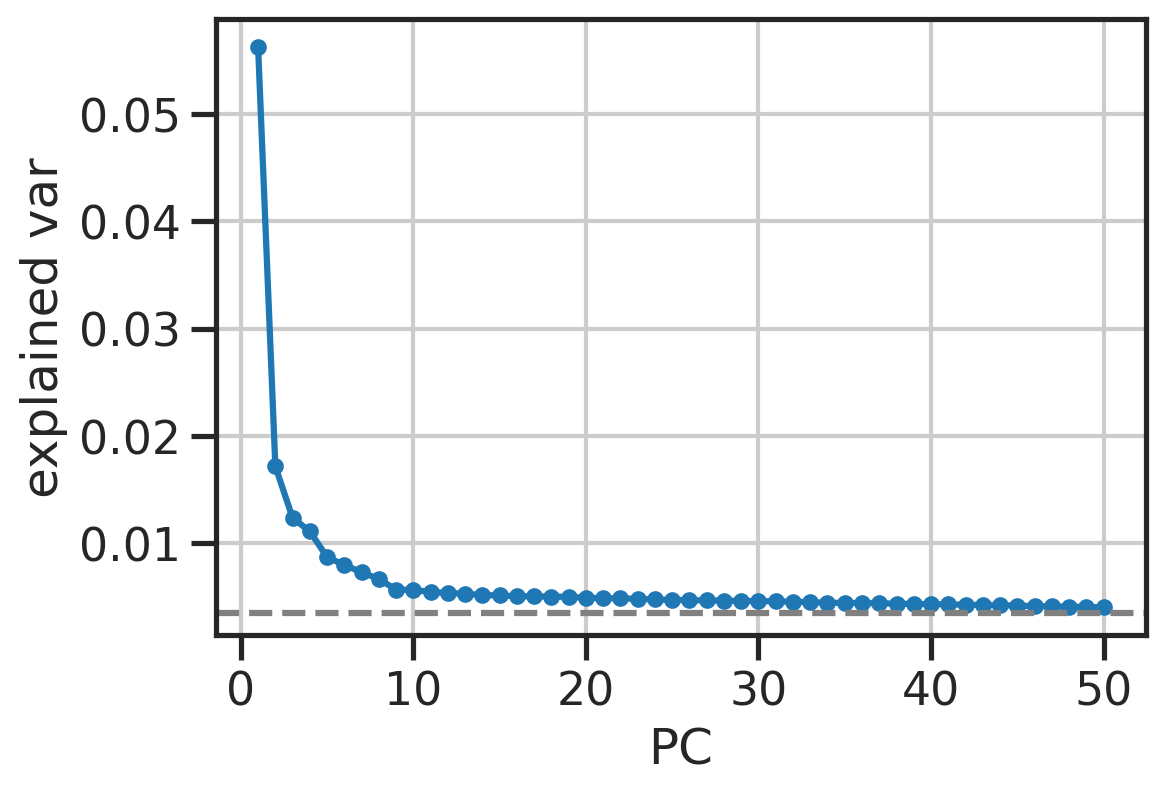

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

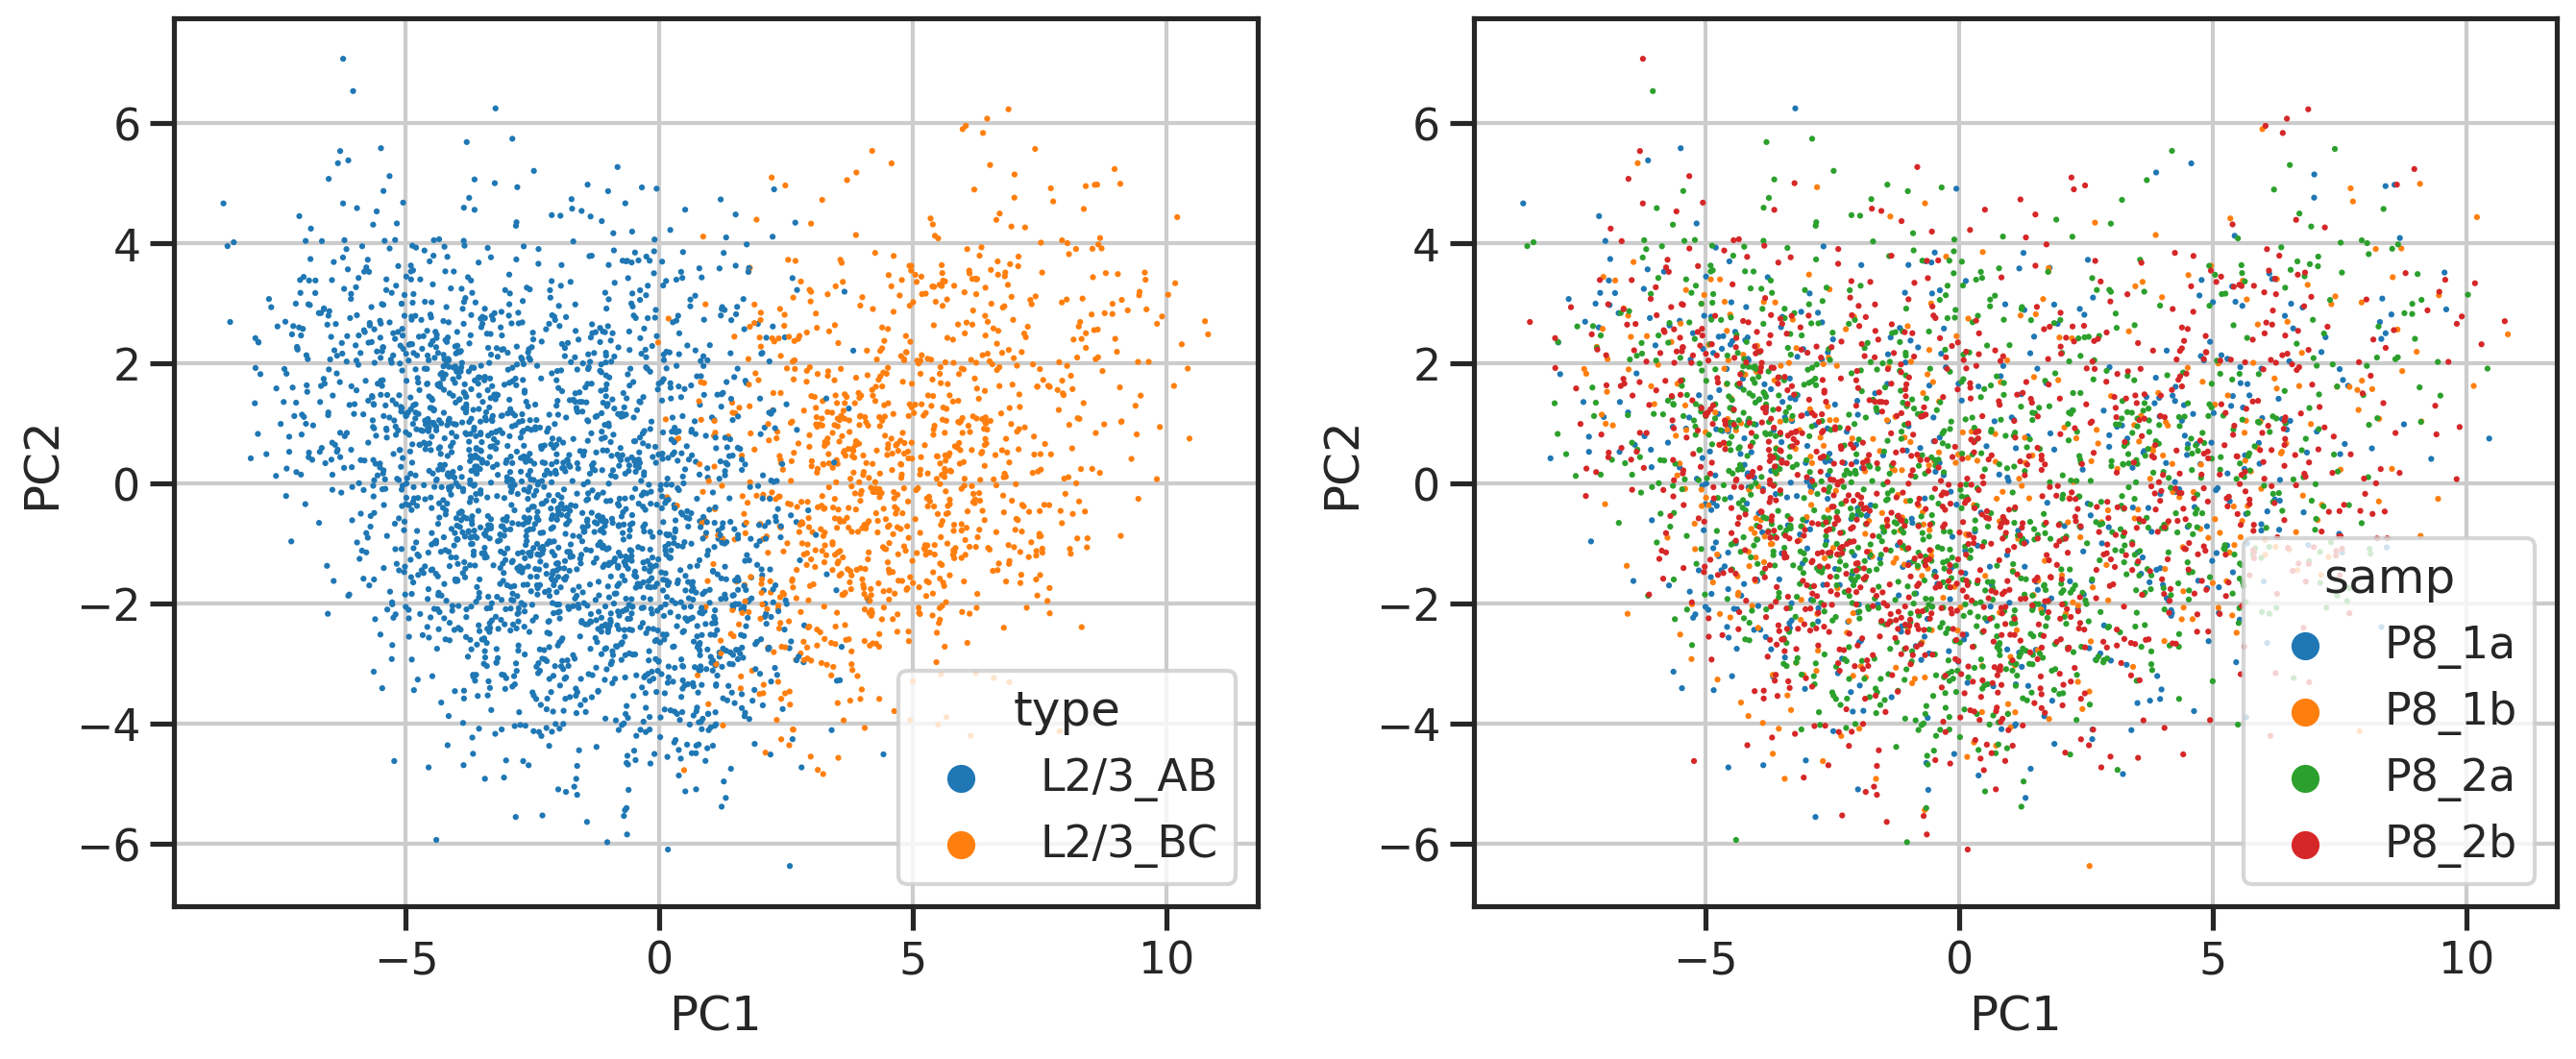

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

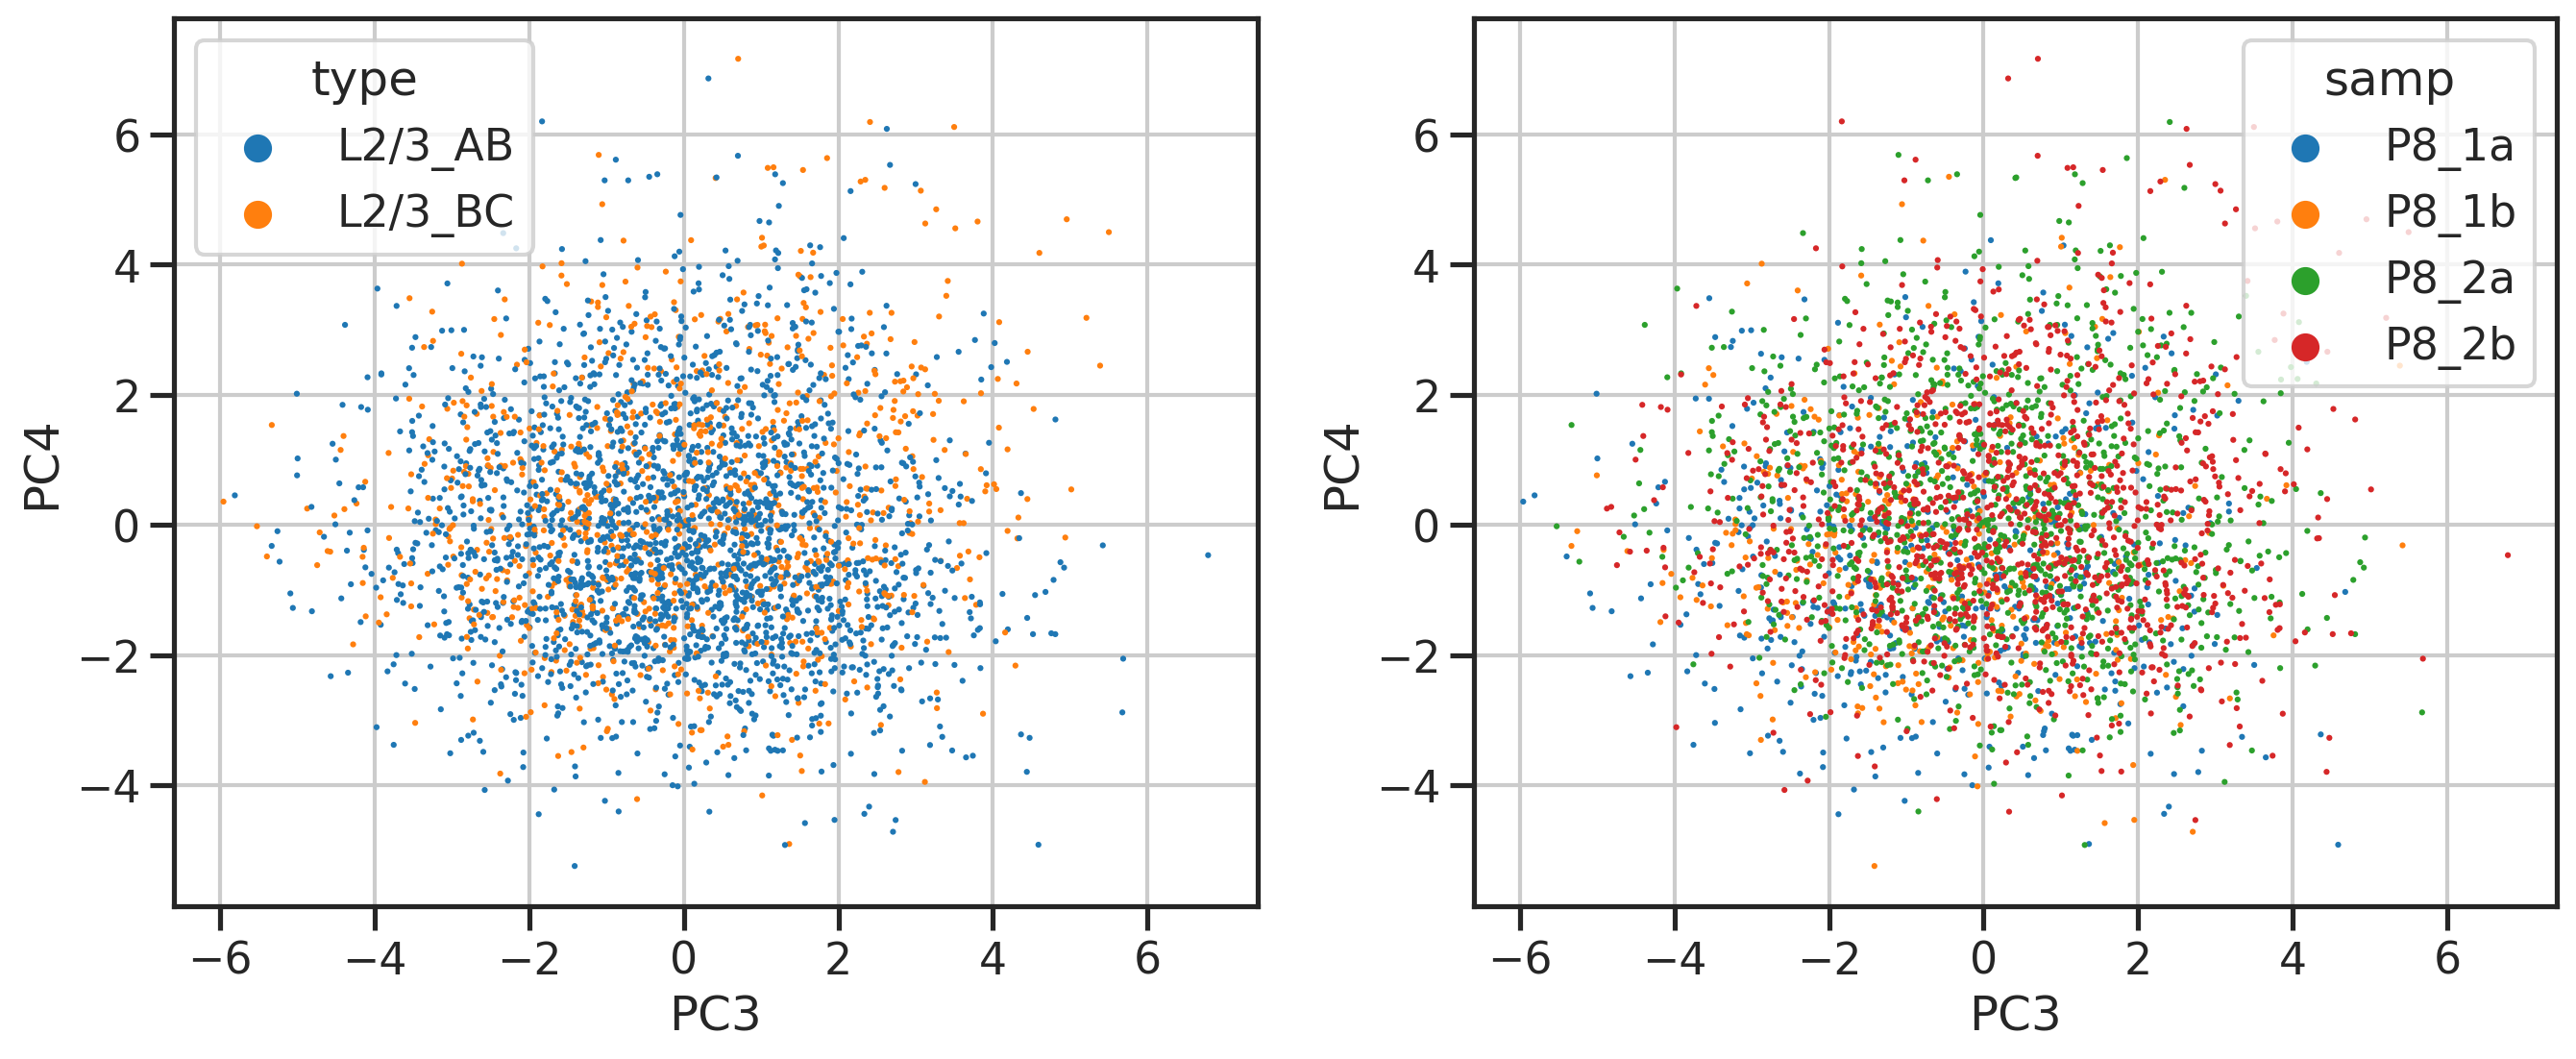

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

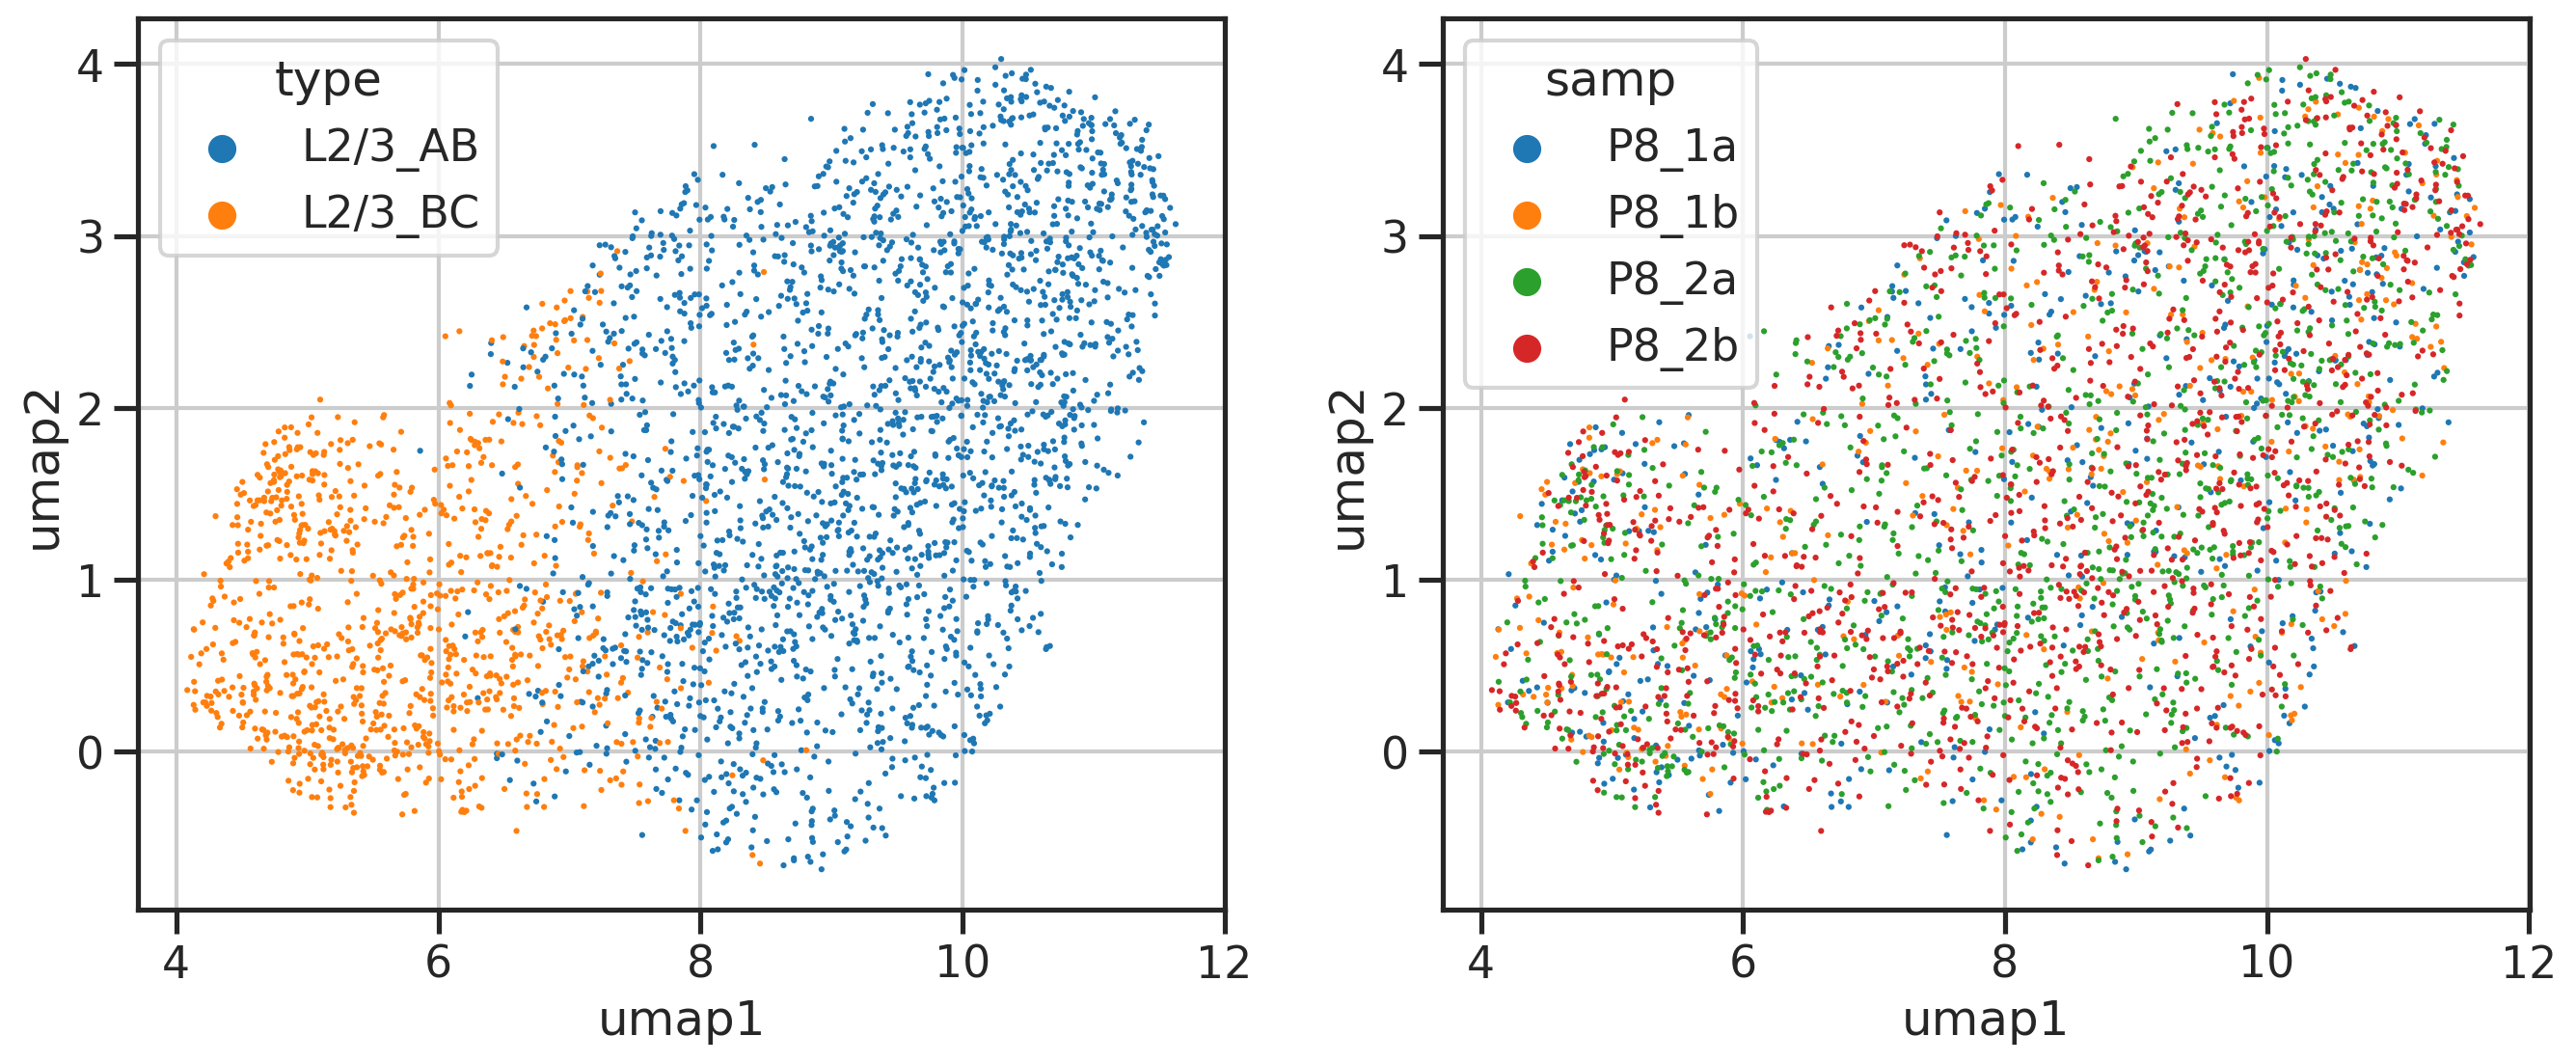

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

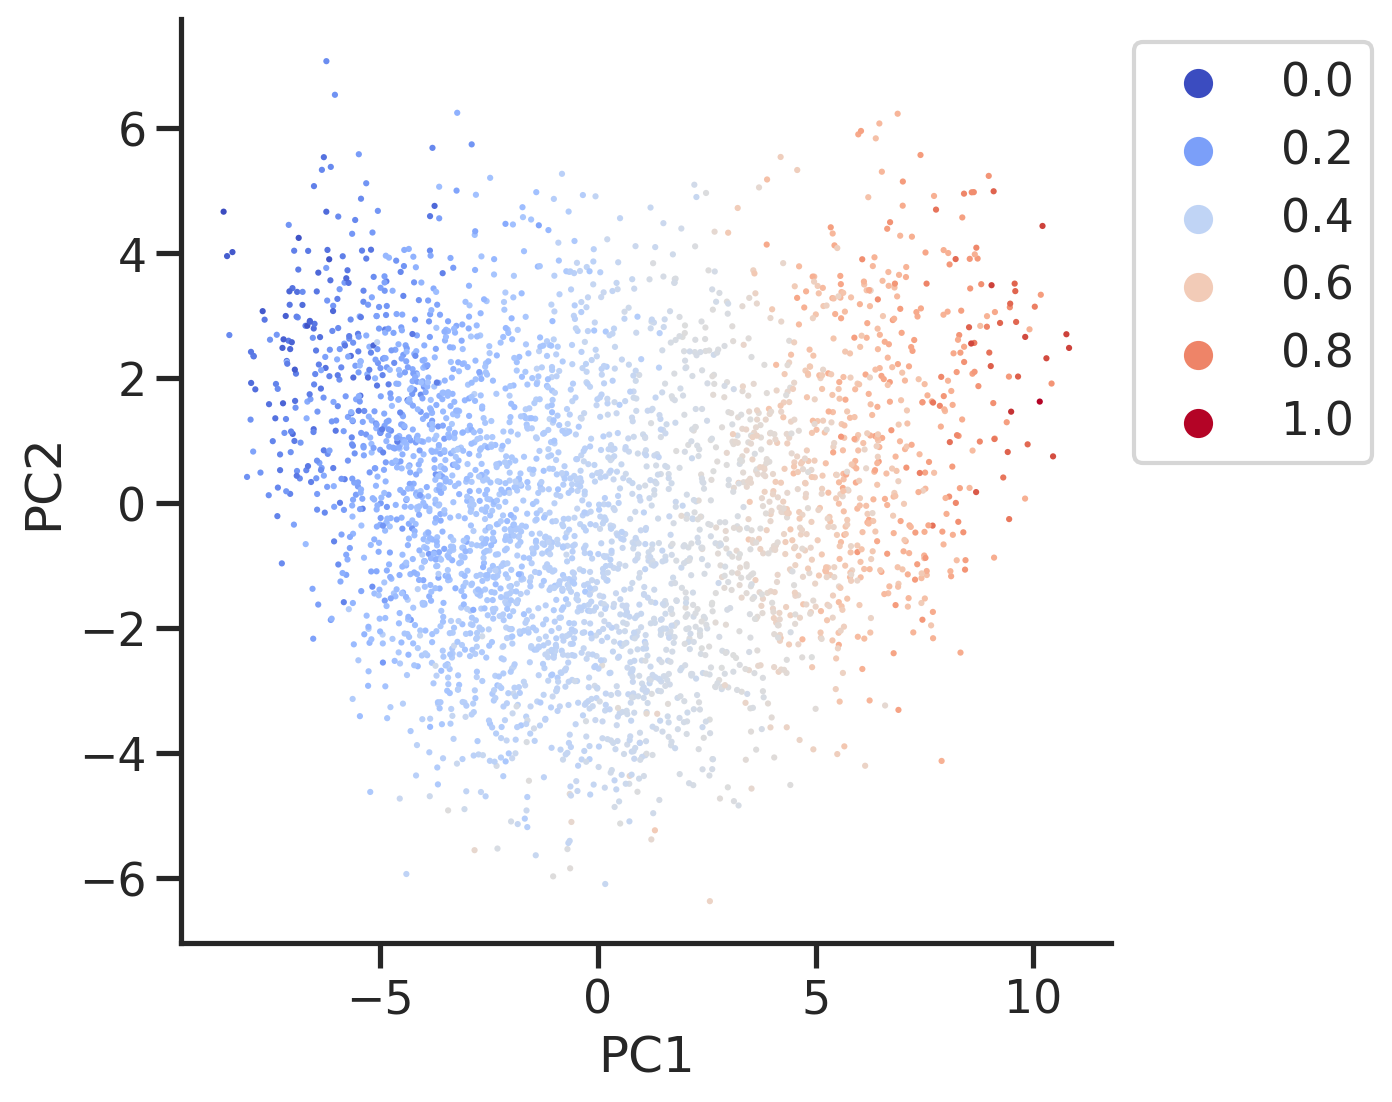

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:03:55 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


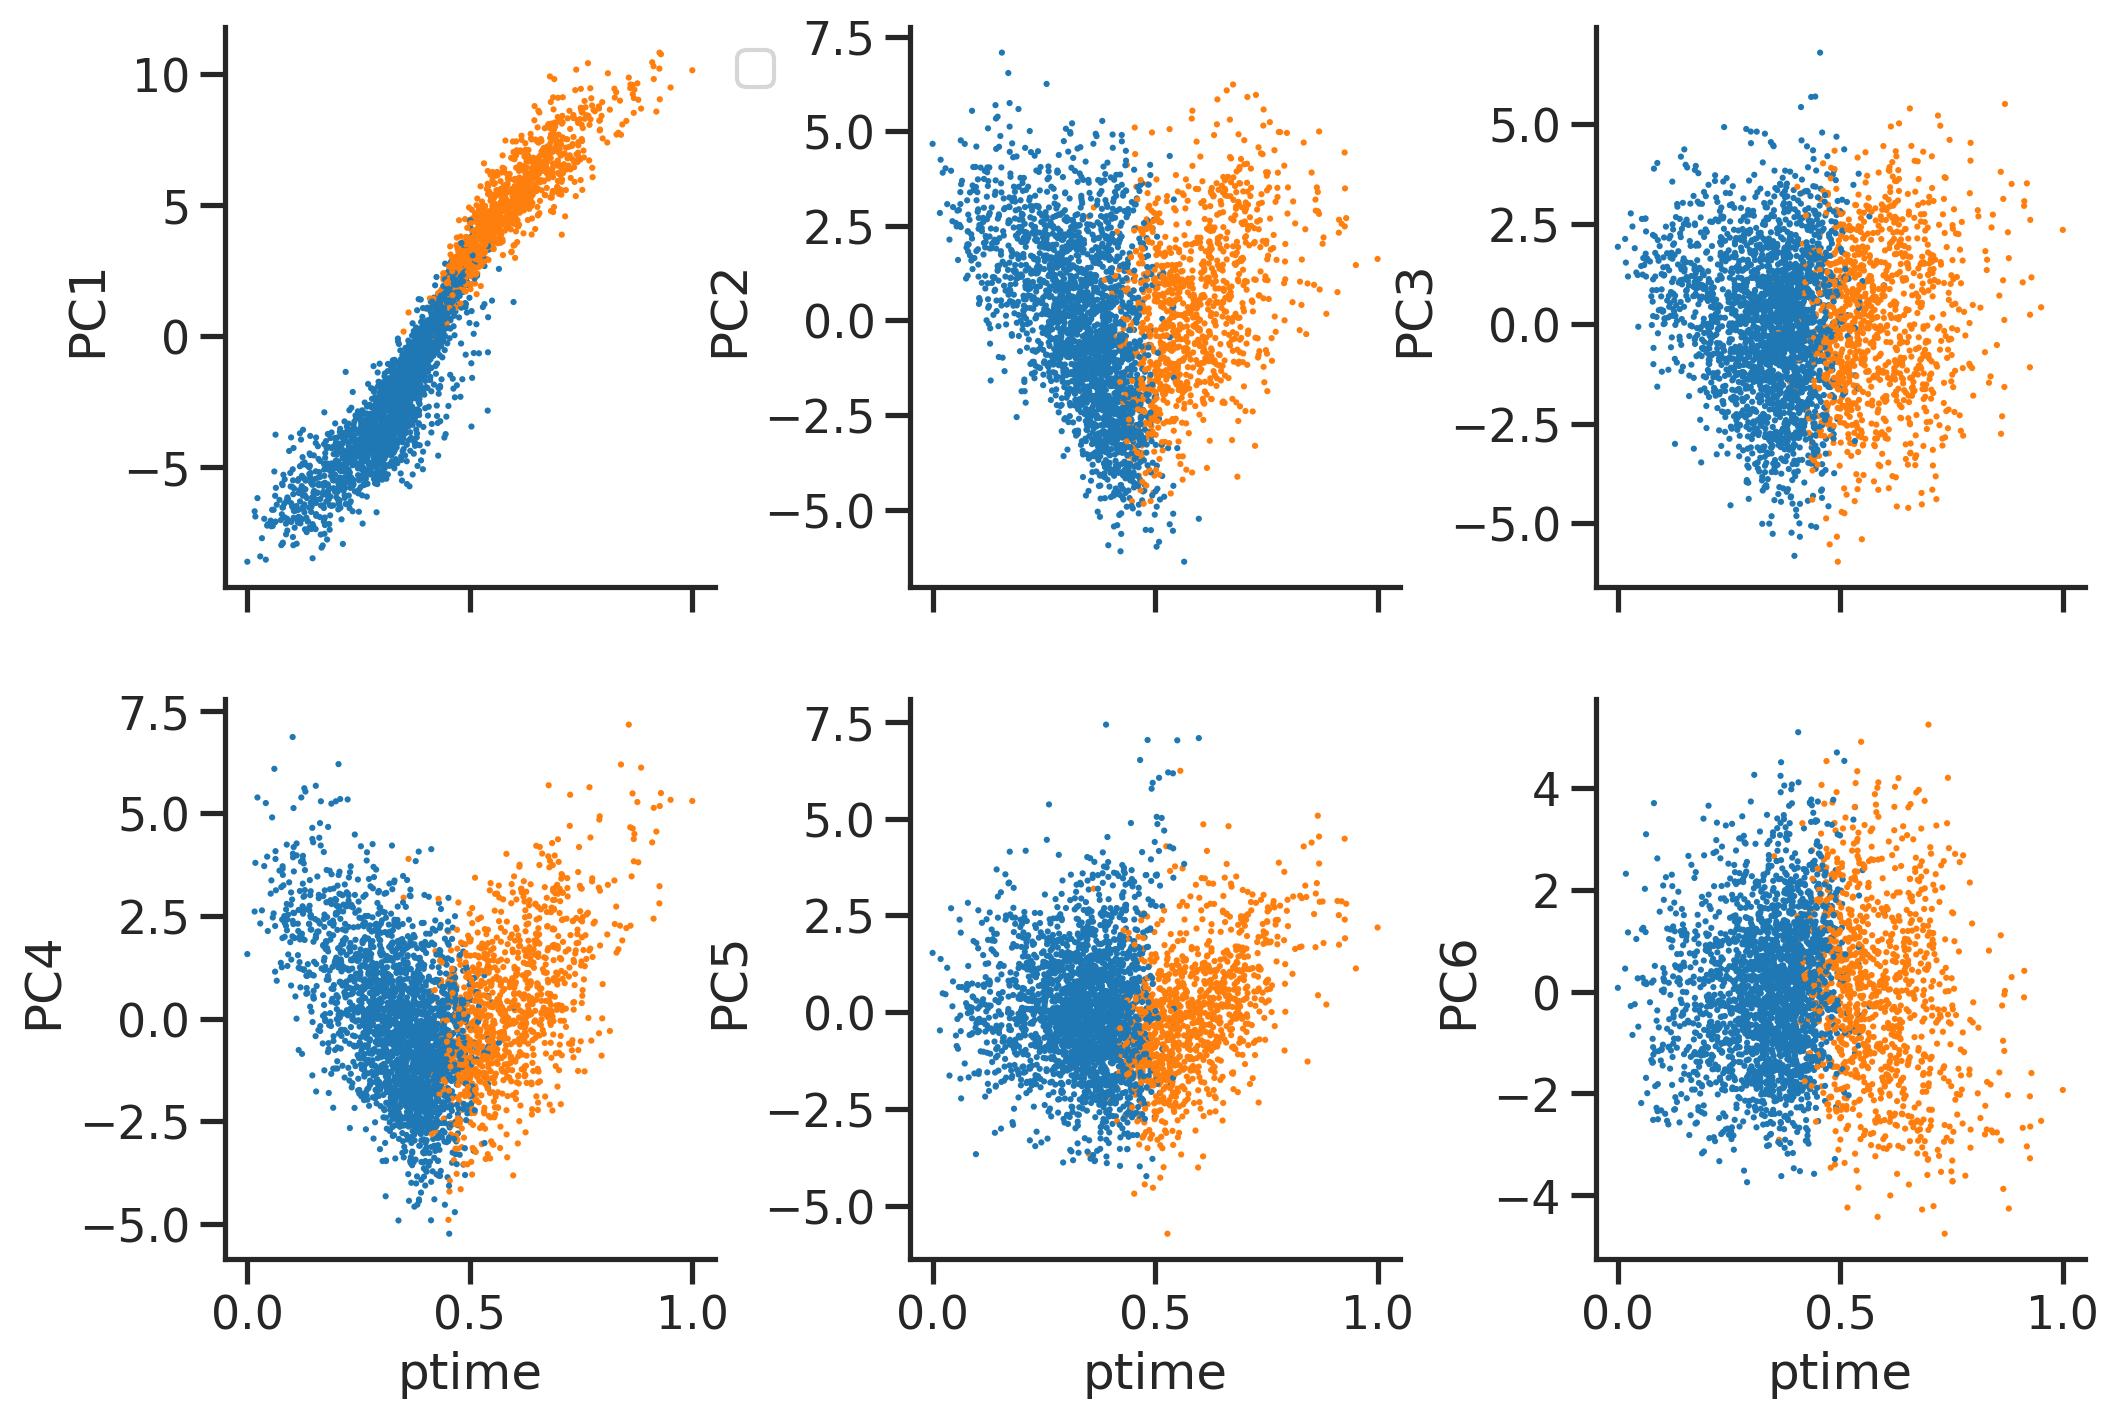

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:04:00 - maxp pruned
03-28 14:04:00 - cmap pruned
03-28 14:04:00 - kern dropped
03-28 14:04:00 - post pruned
03-28 14:04:00 - FFTM dropped
03-28 14:04:00 - GPOS pruned
03-28 14:04:00 - GSUB pruned
03-28 14:04:00 - name pruned
03-28 14:04:00 - glyf pruned
03-28 14:04:00 - Added gid0 to subset
03-28 14:04:00 - Added first four glyphs to subset
03-28 14:04:00 - Closing glyph list over 'GSUB': 34 glyphs before
03-28 14:04:00 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 'e', 'eight', 'five', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:04:00 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 27, 36, 37, 38, 42, 49, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:04:00 - Closed glyph list over 'GSUB': 34 glyphs after
03-28 14:04:00 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P8NR_v4_2023-03-28.pdf


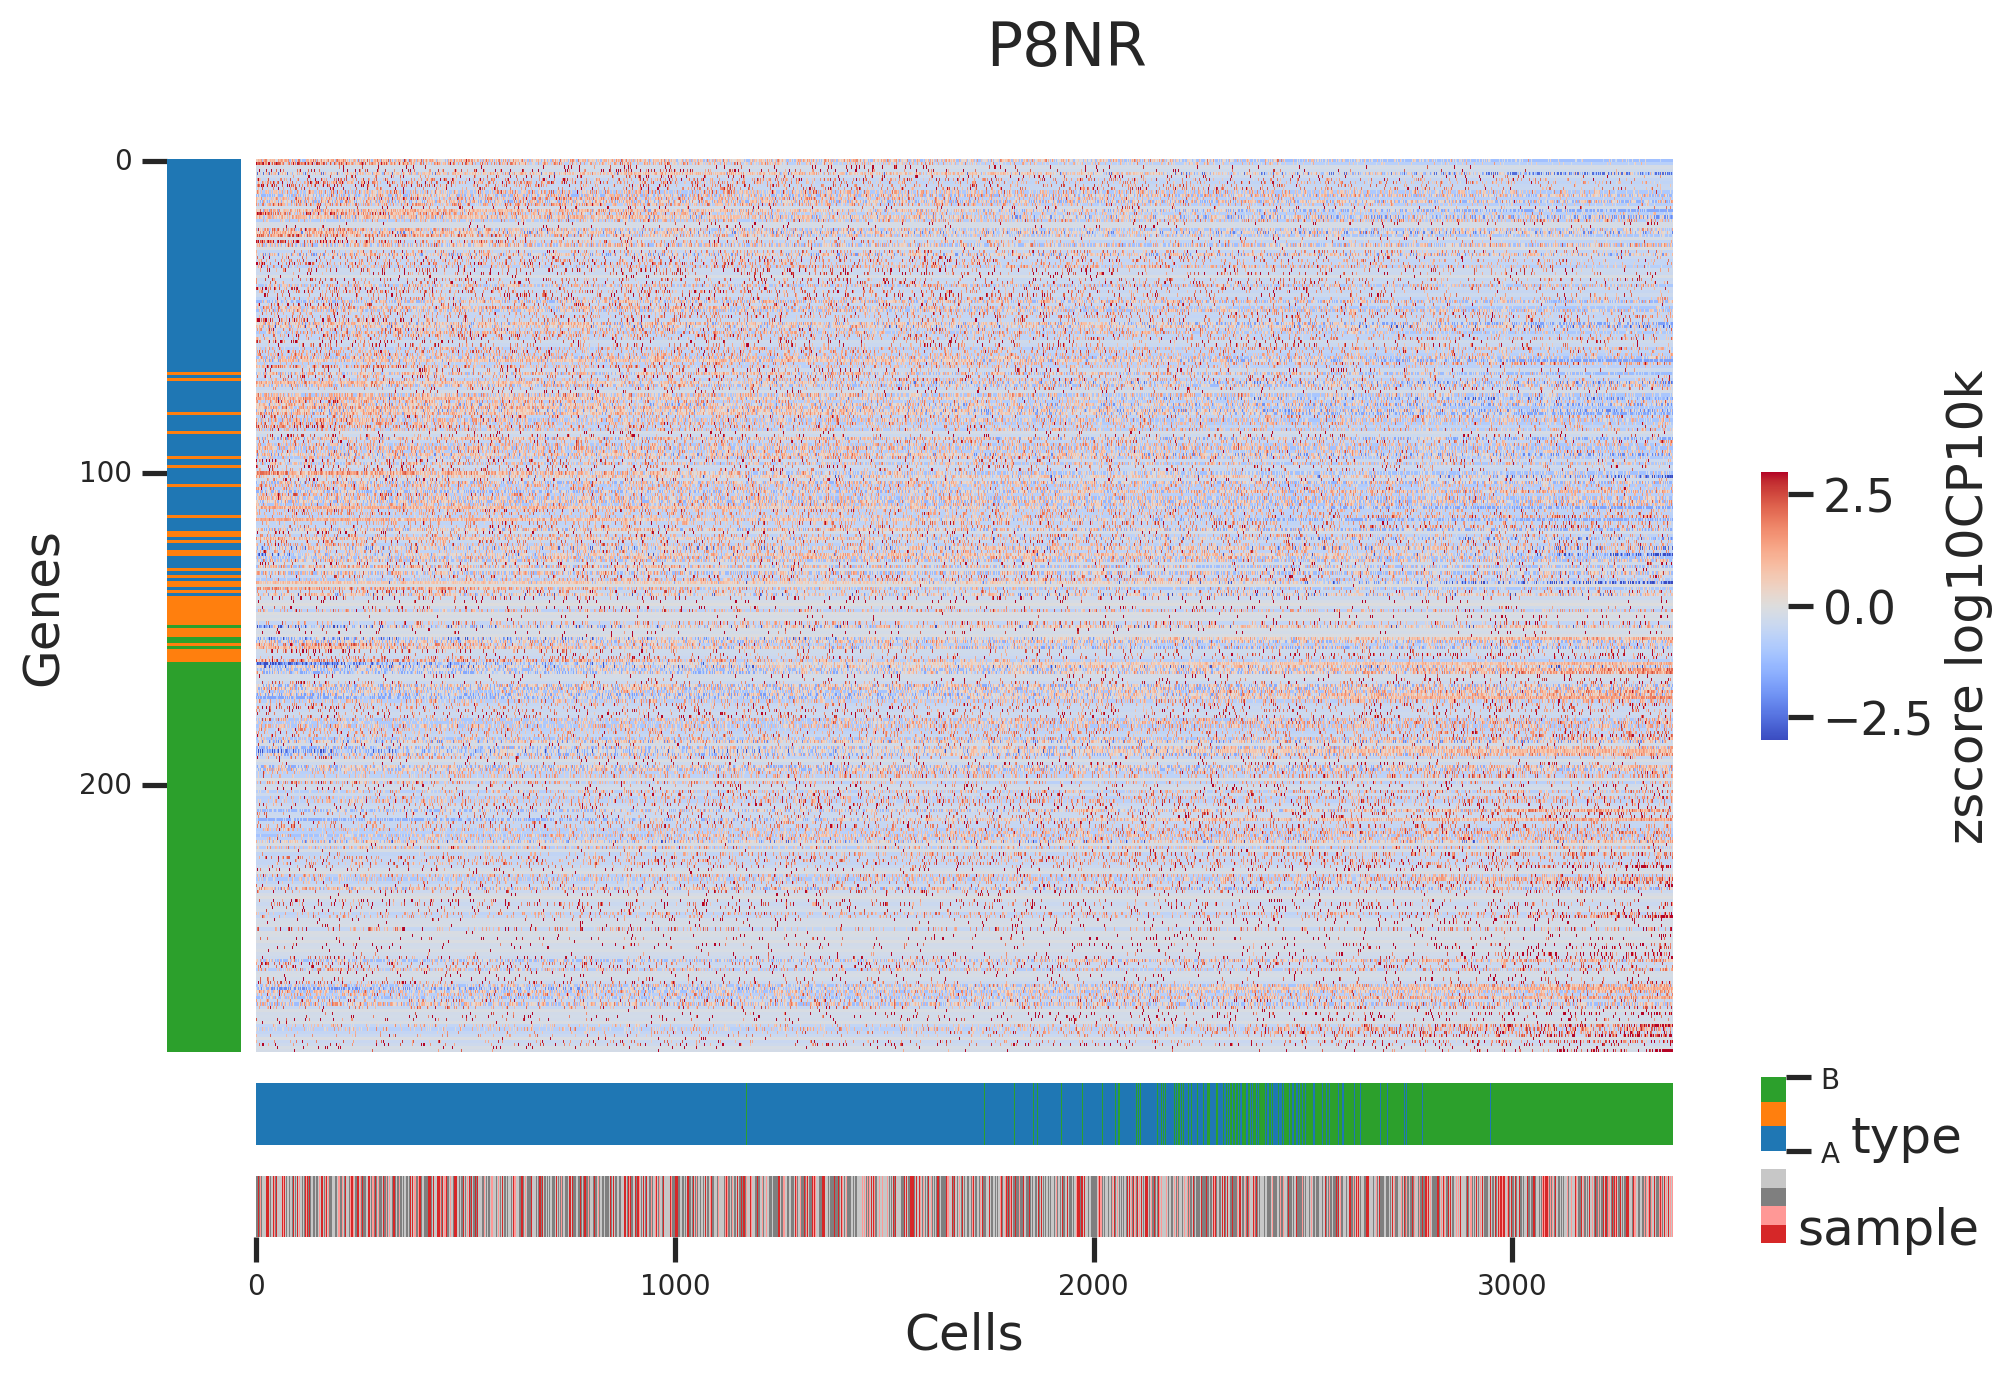

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4       PC5  \
AAACGCTCACTTCATT-1-P8_1a-P8 -4.167515  0.169273  2.574383 -1.589666  2.923386   
AAAGGATAGGTGCATG-1-P8_1a-P8 -5.710969  2.632143 -3.127635  2.985007  0.406603   
AAAGGGCCAGTATACC-1-P8_1a-P8  0.363032 -1.037412 -2.000788 -1.303415  0.173461   
AAAGTCCCATATACCG-1-P8_1a-P8  0.603333 -1.386780 -2.359930 -2.483881  0.671093   
AAAGTCCTCAGATGCT-1-P8_1a-P8  6.168784  3.406447 -1.801495 -2.772495  0.837046   
...                               ...       ...       ...       ...       ...   
TTTGATCCATGAAGCG-1-P8_2b-P8  2.143979 -2.762173  1.618005  0.829782  0.810577   
TTTGATCTCGACGCGT-1-P8_2b-P8 -2.025874 -1.448854 -1.578982  1.097509 -0.770508   
TTTGGAGAGCATCCCG-1-P8_2b-P8  6.425602  0.741534  2.270155 -0.049246 -0.653772   
TTTGGTTGTTCGTAAC-1-P8_2b-P8 -1.702436 -2.044553  0.099648  0.303434 -0.008003   
TTTGTTGAGCACCCAC-1-P8_2b-P8 -2.666442 -0.105466  0.548604 -0.789587  0.628986   

                                  PC6       PC7       PC8       PC9      PC10  \
AAACGCTCACTTCATT-1-P8_1a-P8 -0.120249 -1.950705 -1.732618 -1.321194  0.659689   
AAAGGATAGGTGCATG-1-P8_1a-P8 -0.940489  0.612224  2.176416 -0.839287  3.160024   
AAAGGGCCAGTATACC-1-P8_1a-P8 -1.057998 -0.028259 -0.368191  0.805563  0.139518   
AAAGTCCCATATACCG-1-P8_1a-P8  0.319811  3.409799 -0.692306  0.300376 -0.038912   
AAAGTCCTCAGATGCT-1-P8_1a-P8 -1.310614 -1.121606  1.146196 -1.539873 -2.078232   
...                               ...       ...       ...       ...       ...   
TTTGATCCATGAAGCG-1-P8_2b-P8  2.104926  1.381991  0.504242  1.652107 -0.040561   
TTTGATCTCGACGCGT-1-P8_2b-P8 -0.799096  0.914761  1.293566 -0.917667 -0.680526   
TTTGGAGAGCATCCCG-1-P8_2b-P8 -0.293273 -0.502571 -2.701009  0.592763 -0.198961   
TTTGGTTGTTCGTAAC-1-P8_2b-P8 -0.137710 -0.766244  2.740261 -0.559785  0.657654   
TTTGTTGAGCACCCAC-1-P8_2b-P8  1.910056  0.029462 -2.437411 -2.215843 -0.766762   

                             ...      PC46      PC47      PC48      PC49  \
AAACGCTCACTTCATT-1-P8_1a-P8  ... -0.051205  0.554465 -0.936461  0.380486   
AAAGGATAGGTGCATG-1-P8_1a-P8  ... -0.727801  0.050299 -1.374758 -1.108813   
AAAGGGCCAGTATACC-1-P8_1a-P8  ...  1.049036 -0.068263 -0.248844 -0.860799   
AAAGTCCCATATACCG-1-P8_1a-P8  ...  1.202130 -0.238657 -0.449361  0.308295   
AAAGTCCTCAGATGCT-1-P8_1a-P8  ... -1.622690 -3.319709 -1.509901 -1.380832   
...                          ...       ...       ...       ...       ...   
TTTGATCCATGAAGCG-1-P8_2b-P8  ... -1.079805 -0.902577  0.245160 -2.533897   
TTTGATCTCGACGCGT-1-P8_2b-P8  ... -0.275870  0.282924  1.531418  0.410612   
TTTGGAGAGCATCCCG-1-P8_2b-P8  ... -2.059827  0.716398  2.234955 -0.554415   
TTTGGTTGTTCGTAAC-1-P8_2b-P8  ...  1.239628  0.607229  1.094553 -0.499947   
TTTGTTGAGCACCCAC-1-P8_2b-P8  ...  1.908218 -0.440152 -0.407139 -0.100831   

                                 PC50     type   samp      umap1     umap2  \
AAACGCTCACTTCATT-1-P8_1a-P8 -0.015368  L2/3_AB  P8_1a  10.371646  3.036468   
AAAGGATAGGTGCATG-1-P8_1a-P8 -0.809501  L2/3_AB  P8_1a  11.195108  2.691917   
AAAGGGCCAGTATACC-1-P8_1a-P8  0.422525  L2/3_AB  P8_1a   7.659028  1.148404   
AAAGTCCCATATACCG-1-P8_1a-P8  0.059158  L2/3_AB  P8_1a   7.774300  1.742998   
AAAGTCCTCAGATGCT-1-P8_1a-P8  0.662135  L2/3_BC  P8_1a   4.717086  1.385406   
...                               ...      ...    ...        ...       ...   
TTTGATCCATGAAGCG-1-P8_2b-P8 -0.331784  L2/3_AB  P8_2b   7.435032 -0.058378   
TTTGATCTCGACGCGT-1-P8_2b-P8  0.775247  L2/3_AB  P8_2b   9.919069  1.542040   
TTTGGAGAGCATCCCG-1-P8_2b-P8 -0.123842  L2/3_BC  P8_2b   5.568779  0.657372   
TTTGGTTGTTCGTAAC-1-P8_2b-P8  0.613731  L2/3_AB  P8_2b   9.390076  1.679241   
TTTGTTGAGCACCCAC-1-P8_2b-P8  0.717085  L2/3_AB  P8_2b   9.874743  1.531768   

                                ptime  
AAACGCTCACTTCATT-1-P8_1a-P8  0.276352  
AAAGGATAGGTGCATG-1-P8_1a-P8  0.170780  
AAAGGGCCAGTATACC-1-P8_1a-P8  0.426782  
AAAGTCCCATATACCG-1-P8_1a-P8  0.425401  
AAAGTCCTCAGATGCT-1-P8_1a-P8  0.625315 

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)